# Imports

In [45]:

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")



# Load datasets

In [46]:
import data_func.read_data as read_data

dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [47]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]


In [48]:
print(len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 00:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))


136245
Index([118664], dtype='int64')
136244


# Data clean up

[]
[635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 707, 708, 709, 710, 711, 712, 713, 1348, 1349, 1350, 1351, 1352, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256,

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

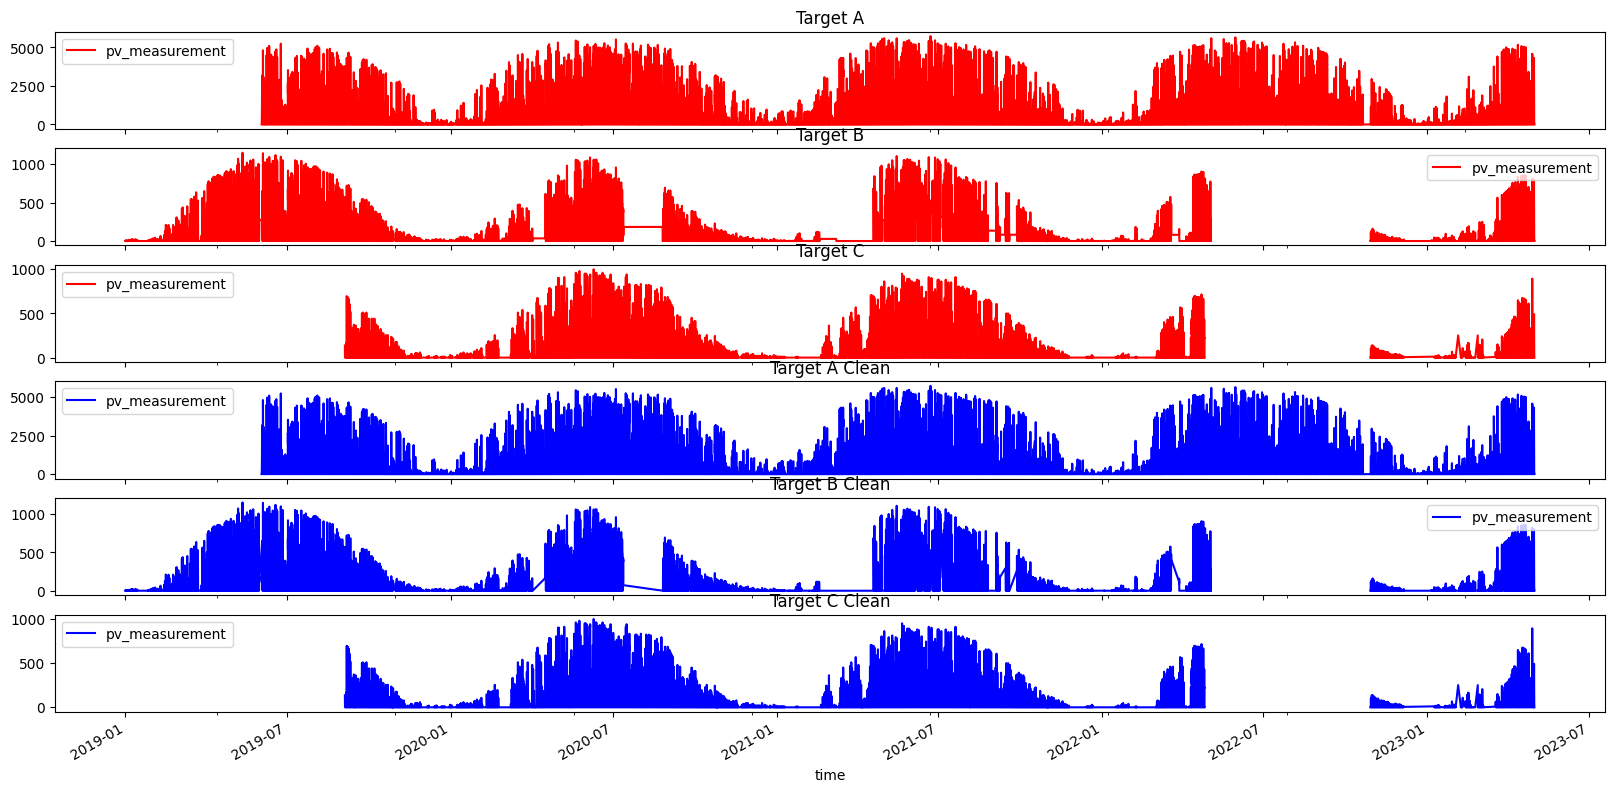

In [49]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data aggregation


In [50]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])


In [51]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))


x,y:  34060 34060
x,y:  25996 25996
x,y:  23099 23099


# Feature engineering

In [52]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
import data_func.date_forecast as DF
for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    X_train[i] = DF.date_forecast_columns(X_train[i])

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = DF.date_forecast_columns(X_frames_test[i])    
 

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
    temp = pd.concat([train, test], ignore_index=True)
    index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
    return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i].drop(columns=['date_forecast'], inplace=True)
     X_frames_test[i].drop(columns=['date_forecast'], inplace=True)


# Datacleaning

In [53]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,6126,3609,4342
cloud_base_agl:m,2362,1367,1686
snow_density:kgm3,32920,24141,21686


In [54]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720
precip_type_5min:idx_5,720,720,720


In [55]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)


In [56]:
x_train_c.head()


,is_day:idx,is_in_shadow:idx,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_point_2m:K,diffuse_rad:W,...,day,hours,dew_or_rime:idx_-1,dew_or_rime:idx_0,dew_or_rime:idx_1,precip_type_5min:idx_0,precip_type_5min:idx_1,precip_type_5min:idx_2,precip_type_5min:idx_3,precip_type_5min:idx_5
21378,0,1,4.400,1.24350,3745.550049,0.000,0.000000,2951.925049,272.049988,0.000000,...,13,1,0,1,0,0,1,0,0,0
20402,1,1,4.275,1.24025,6935.250000,3840.875,4.800000,4463.649902,271.475006,5.150000,...,3,9,1,0,0,1,0,0,0,0
19234,0,1,5.275,1.27825,1523.949951,0.000,0.000000,1520.250000,274.500000,0.000000,...,15,17,0,0,1,1,0,0,0,0
15829,1,0,8.875,1.22450,4295.774902,1371859.500,315.924988,1443.324951,282.524994,64.324997,...,26,17,0,1,0,1,0,0,0,0
6868,1,0,12.675,1.18725,20000.000000,470560.000,83.900002,1879.300171,288.350006,35.549999,...,16,19,0,1,0,1,0,0,0,0


# Hyperparameter optimization

In [57]:
import optuna
import catboost as cat # Change to model to optimize
# Split the data into training and validation sets

x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_train[0], Y_train[0], test_size=0.17, random_state=None)
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_train[1], Y_train[1], test_size=0.17, random_state=None)
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_train[2], Y_train[2], test_size=0.17, random_state=None)

categorical_column = ['dew_or_rime:idx_-1',	'dew_or_rime:idx_0','dew_or_rime:idx_1', 'precip_type_5min:idx_0','precip_type_5min:idx_1','precip_type_5min:idx_2','precip_type_5min:idx_3','precip_type_5min:idx_5', 'is_day:idx', 'is_in_shadow:idx']

def objective(trial):
    
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "cat_features": categorical_column,
        "random_seed": 42,
        "loss_function": "MAE",
        "eval_metric": "MAE",
    }

    model_a = cat.CatBoostRegressor(**params) # Change to model to optimize
    model_a.fit(x_train_a, y_train_a)

    # Make predictions on the validation set
    y_pred = model_a.predict(x_val_a)

    # Calculate the Mean Squared Error (MSE) as the metric to optimize
    mae = mean_absolute_error(y_val_a, y_pred)

    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best = study.best_params
# Print the best hyperparameters foundc
print("Best hyperparameters:", best)


[I 2023-10-31 19:33:10,504] A new study created in memory with name: no-name-1ca108d3-8400-49cc-b73c-70561203d220


0:	learn: 595.7710231	total: 14.8ms	remaining: 14.8s
1:	learn: 561.3233936	total: 27.4ms	remaining: 13.6s
2:	learn: 526.2222983	total: 37.9ms	remaining: 12.6s
3:	learn: 485.9119328	total: 45.7ms	remaining: 11.4s
4:	learn: 450.3840360	total: 53.3ms	remaining: 10.6s
5:	learn: 420.3841860	total: 60.6ms	remaining: 10s
6:	learn: 392.7839742	total: 66.6ms	remaining: 9.45s
7:	learn: 368.7871831	total: 72.5ms	remaining: 8.98s
8:	learn: 349.8781507	total: 79ms	remaining: 8.7s
9:	learn: 332.8975700	total: 85.1ms	remaining: 8.43s
10:	learn: 317.3511036	total: 91.1ms	remaining: 8.19s
11:	learn: 308.0310003	total: 97ms	remaining: 7.99s
12:	learn: 297.0032179	total: 102ms	remaining: 7.77s
13:	learn: 284.9210692	total: 108ms	remaining: 7.63s
14:	learn: 274.1417608	total: 115ms	remaining: 7.56s
15:	learn: 265.2467423	total: 121ms	remaining: 7.45s
16:	learn: 257.4229202	total: 128ms	remaining: 7.39s
17:	learn: 251.6929736	total: 134ms	remaining: 7.31s
18:	learn: 246.5591803	total: 140ms	remaining: 7.23

[I 2023-10-31 19:33:16,029] Trial 0 finished with value: 179.69658885492083 and parameters: {'learning_rate': 0.09566223811599815, 'depth': 7, 'subsample': 0.960801961471582, 'colsample_bylevel': 0.6043383106745279, 'min_data_in_leaf': 78}. Best is trial 0 with value: 179.69658885492083.


977:	learn: 139.0116260	total: 5.25s	remaining: 118ms
978:	learn: 139.0035966	total: 5.26s	remaining: 113ms
979:	learn: 138.9988262	total: 5.26s	remaining: 107ms
980:	learn: 138.9768494	total: 5.27s	remaining: 102ms
981:	learn: 138.9291285	total: 5.28s	remaining: 96.7ms
982:	learn: 138.8931805	total: 5.28s	remaining: 91.4ms
983:	learn: 138.8770055	total: 5.29s	remaining: 86ms
984:	learn: 138.8733041	total: 5.29s	remaining: 80.6ms
985:	learn: 138.7632415	total: 5.3s	remaining: 75.2ms
986:	learn: 138.7548323	total: 5.3s	remaining: 69.9ms
987:	learn: 138.6847633	total: 5.31s	remaining: 64.5ms
988:	learn: 138.6220469	total: 5.31s	remaining: 59.1ms
989:	learn: 138.6155061	total: 5.32s	remaining: 53.7ms
990:	learn: 138.5876271	total: 5.33s	remaining: 48.4ms
991:	learn: 138.5871047	total: 5.33s	remaining: 43ms
992:	learn: 138.5714777	total: 5.34s	remaining: 37.6ms
993:	learn: 138.5700539	total: 5.34s	remaining: 32.2ms
994:	learn: 138.5522055	total: 5.35s	remaining: 26.9ms
995:	learn: 138.5212

[I 2023-10-31 19:33:29,331] Trial 1 finished with value: 195.29407566447563 and parameters: {'learning_rate': 0.0066561319202220704, 'depth': 10, 'subsample': 0.17836033605792734, 'colsample_bylevel': 0.7357421970971967, 'min_data_in_leaf': 67}. Best is trial 0 with value: 179.69658885492083.


990:	learn: 176.1230746	total: 13s	remaining: 118ms
991:	learn: 176.1045963	total: 13s	remaining: 105ms
992:	learn: 176.0907970	total: 13s	remaining: 91.8ms
993:	learn: 176.0592645	total: 13s	remaining: 78.7ms
994:	learn: 176.0443508	total: 13.1s	remaining: 65.6ms
995:	learn: 176.0181979	total: 13.1s	remaining: 52.5ms
996:	learn: 176.0123992	total: 13.1s	remaining: 39.3ms
997:	learn: 175.9852295	total: 13.1s	remaining: 26.2ms
998:	learn: 175.9776256	total: 13.1s	remaining: 13.1ms
999:	learn: 175.9613770	total: 13.1s	remaining: 0us
0:	learn: 623.6456915	total: 4.18ms	remaining: 4.17s
1:	learn: 617.9107580	total: 7.62ms	remaining: 3.8s
2:	learn: 611.9417796	total: 11.2ms	remaining: 3.73s
3:	learn: 604.5583278	total: 15ms	remaining: 3.75s
4:	learn: 597.6790546	total: 19.3ms	remaining: 3.85s
5:	learn: 592.4163096	total: 22.9ms	remaining: 3.79s
6:	learn: 586.0938746	total: 26.7ms	remaining: 3.78s
7:	learn: 579.7834095	total: 30.4ms	remaining: 3.77s
8:	learn: 573.3678302	total: 34.1ms	remain

[I 2023-10-31 19:33:32,294] Trial 2 finished with value: 202.96485396632124 and parameters: {'learning_rate': 0.014703696723078988, 'depth': 5, 'subsample': 0.3580970219483077, 'colsample_bylevel': 0.9532443323902864, 'min_data_in_leaf': 100}. Best is trial 0 with value: 179.69658885492083.


976:	learn: 192.5149760	total: 2.81s	remaining: 66.1ms
977:	learn: 192.5009424	total: 2.81s	remaining: 63.2ms
978:	learn: 192.4716673	total: 2.81s	remaining: 60.4ms
979:	learn: 192.4079766	total: 2.82s	remaining: 57.5ms
980:	learn: 192.4054329	total: 2.82s	remaining: 54.6ms
981:	learn: 192.4051598	total: 2.82s	remaining: 51.7ms
982:	learn: 192.4044944	total: 2.83s	remaining: 48.9ms
983:	learn: 192.3996851	total: 2.83s	remaining: 46ms
984:	learn: 192.3553489	total: 2.83s	remaining: 43.1ms
985:	learn: 192.3435525	total: 2.83s	remaining: 40.2ms
986:	learn: 192.3242603	total: 2.84s	remaining: 37.4ms
987:	learn: 192.3126292	total: 2.84s	remaining: 34.5ms
988:	learn: 192.2884209	total: 2.84s	remaining: 31.6ms
989:	learn: 192.2804731	total: 2.84s	remaining: 28.7ms
990:	learn: 192.2676105	total: 2.85s	remaining: 25.9ms
991:	learn: 192.2490223	total: 2.85s	remaining: 23ms
992:	learn: 192.2185747	total: 2.85s	remaining: 20.1ms
993:	learn: 192.2054427	total: 2.85s	remaining: 17.2ms
994:	learn: 19

[I 2023-10-31 19:33:33,776] Trial 3 finished with value: 215.80579320471193 and parameters: {'learning_rate': 0.04376854185970061, 'depth': 2, 'subsample': 0.29515407147946193, 'colsample_bylevel': 0.09163443017255689, 'min_data_in_leaf': 45}. Best is trial 0 with value: 179.69658885492083.


905:	learn: 207.3555830	total: 1.27s	remaining: 131ms
906:	learn: 207.3521023	total: 1.27s	remaining: 130ms
907:	learn: 207.3516016	total: 1.27s	remaining: 129ms
908:	learn: 207.3493558	total: 1.27s	remaining: 127ms
909:	learn: 207.3458547	total: 1.27s	remaining: 126ms
910:	learn: 207.3458503	total: 1.27s	remaining: 124ms
911:	learn: 207.3454829	total: 1.27s	remaining: 123ms
912:	learn: 207.3454770	total: 1.28s	remaining: 122ms
913:	learn: 207.3323532	total: 1.28s	remaining: 120ms
914:	learn: 207.3021771	total: 1.28s	remaining: 119ms
915:	learn: 207.3020200	total: 1.28s	remaining: 118ms
916:	learn: 207.3019828	total: 1.28s	remaining: 116ms
917:	learn: 207.2767204	total: 1.28s	remaining: 115ms
918:	learn: 207.2765278	total: 1.29s	remaining: 114ms
919:	learn: 207.2733142	total: 1.29s	remaining: 112ms
920:	learn: 207.2732730	total: 1.29s	remaining: 111ms
921:	learn: 207.2732303	total: 1.29s	remaining: 109ms
922:	learn: 207.2683940	total: 1.29s	remaining: 108ms
923:	learn: 207.2683716	tota

[I 2023-10-31 19:33:36,544] Trial 4 finished with value: 194.3491119035382 and parameters: {'learning_rate': 0.06386774350713566, 'depth': 4, 'subsample': 0.9079399589673789, 'colsample_bylevel': 0.6281701563528888, 'min_data_in_leaf': 41}. Best is trial 0 with value: 179.69658885492083.


975:	learn: 178.0147545	total: 2.61s	remaining: 64.2ms
976:	learn: 177.9923279	total: 2.61s	remaining: 61.5ms
977:	learn: 177.9701429	total: 2.62s	remaining: 58.9ms
978:	learn: 177.9701182	total: 2.62s	remaining: 56.2ms
979:	learn: 177.9659576	total: 2.62s	remaining: 53.5ms
980:	learn: 177.9608694	total: 2.62s	remaining: 50.8ms
981:	learn: 177.9608632	total: 2.63s	remaining: 48.1ms
982:	learn: 177.9608632	total: 2.63s	remaining: 45.5ms
983:	learn: 177.9608429	total: 2.63s	remaining: 42.8ms
984:	learn: 177.9603340	total: 2.63s	remaining: 40.1ms
985:	learn: 177.9087268	total: 2.64s	remaining: 37.4ms
986:	learn: 177.9087167	total: 2.64s	remaining: 34.8ms
987:	learn: 177.9073279	total: 2.64s	remaining: 32.1ms
988:	learn: 177.8861349	total: 2.64s	remaining: 29.4ms
989:	learn: 177.8860581	total: 2.65s	remaining: 26.7ms
990:	learn: 177.8834276	total: 2.65s	remaining: 24.1ms
991:	learn: 177.8715907	total: 2.65s	remaining: 21.4ms
992:	learn: 177.8715906	total: 2.65s	remaining: 18.7ms
993:	learn

[I 2023-10-31 19:33:38,858] Trial 5 finished with value: 199.08631608922826 and parameters: {'learning_rate': 0.03262590722349031, 'depth': 4, 'subsample': 0.5513047779979561, 'colsample_bylevel': 0.3315269987658391, 'min_data_in_leaf': 80}. Best is trial 0 with value: 179.69658885492083.


929:	learn: 187.6449488	total: 2.08s	remaining: 157ms
930:	learn: 187.6350136	total: 2.08s	remaining: 154ms
931:	learn: 187.6349989	total: 2.08s	remaining: 152ms
932:	learn: 187.5656498	total: 2.08s	remaining: 150ms
933:	learn: 187.5305121	total: 2.09s	remaining: 148ms
934:	learn: 187.5291169	total: 2.09s	remaining: 145ms
935:	learn: 187.4901419	total: 2.09s	remaining: 143ms
936:	learn: 187.4892175	total: 2.09s	remaining: 141ms
937:	learn: 187.4856685	total: 2.1s	remaining: 139ms
938:	learn: 187.4854212	total: 2.1s	remaining: 136ms
939:	learn: 187.4256645	total: 2.1s	remaining: 134ms
940:	learn: 187.3857910	total: 2.1s	remaining: 132ms
941:	learn: 187.3819849	total: 2.1s	remaining: 130ms
942:	learn: 187.3259726	total: 2.11s	remaining: 127ms
943:	learn: 187.3251975	total: 2.11s	remaining: 125ms
944:	learn: 187.2746703	total: 2.11s	remaining: 123ms
945:	learn: 187.2728996	total: 2.11s	remaining: 121ms
946:	learn: 187.2728604	total: 2.12s	remaining: 118ms
947:	learn: 187.2431927	total: 2.

[I 2023-10-31 19:33:41,394] Trial 6 finished with value: 232.39442352388363 and parameters: {'learning_rate': 0.02236807275561056, 'depth': 2, 'subsample': 0.8869888992560164, 'colsample_bylevel': 0.6975705642828158, 'min_data_in_leaf': 10}. Best is trial 0 with value: 179.69658885492083.


976:	learn: 224.4860885	total: 2.4s	remaining: 56.5ms
977:	learn: 224.4860885	total: 2.4s	remaining: 54.1ms
978:	learn: 224.4860885	total: 2.41s	remaining: 51.6ms
979:	learn: 224.4854093	total: 2.41s	remaining: 49.2ms
980:	learn: 224.4854093	total: 2.41s	remaining: 46.7ms
981:	learn: 224.4854092	total: 2.41s	remaining: 44.2ms
982:	learn: 224.4854092	total: 2.42s	remaining: 41.8ms
983:	learn: 224.4854092	total: 2.42s	remaining: 39.3ms
984:	learn: 224.4854086	total: 2.42s	remaining: 36.9ms
985:	learn: 224.4846411	total: 2.42s	remaining: 34.4ms
986:	learn: 224.4846411	total: 2.42s	remaining: 31.9ms
987:	learn: 224.4846411	total: 2.43s	remaining: 29.5ms
988:	learn: 224.4846407	total: 2.43s	remaining: 27ms
989:	learn: 224.4846403	total: 2.43s	remaining: 24.6ms
990:	learn: 224.4846400	total: 2.43s	remaining: 22.1ms
991:	learn: 224.4846400	total: 2.44s	remaining: 19.6ms
992:	learn: 224.4846400	total: 2.44s	remaining: 17.2ms
993:	learn: 224.4846400	total: 2.44s	remaining: 14.7ms
994:	learn: 22

[I 2023-10-31 19:33:44,648] Trial 7 finished with value: 248.08509106962464 and parameters: {'learning_rate': 0.002406720216204566, 'depth': 4, 'subsample': 0.8905133110764502, 'colsample_bylevel': 0.589941136701994, 'min_data_in_leaf': 15}. Best is trial 0 with value: 179.69658885492083.


979:	learn: 240.5810067	total: 3.1s	remaining: 63.4ms
980:	learn: 240.5001969	total: 3.11s	remaining: 60.2ms
981:	learn: 240.4157136	total: 3.11s	remaining: 57ms
982:	learn: 240.3344542	total: 3.11s	remaining: 53.8ms
983:	learn: 240.2927701	total: 3.12s	remaining: 50.7ms
984:	learn: 240.2241993	total: 3.12s	remaining: 47.5ms
985:	learn: 240.1469805	total: 3.12s	remaining: 44.4ms
986:	learn: 240.0463015	total: 3.13s	remaining: 41.2ms
987:	learn: 239.9601355	total: 3.13s	remaining: 38ms
988:	learn: 239.8736041	total: 3.13s	remaining: 34.9ms
989:	learn: 239.8501164	total: 3.14s	remaining: 31.7ms
990:	learn: 239.7669078	total: 3.14s	remaining: 28.5ms
991:	learn: 239.6724364	total: 3.14s	remaining: 25.4ms
992:	learn: 239.5892918	total: 3.15s	remaining: 22.2ms
993:	learn: 239.5091595	total: 3.15s	remaining: 19ms
994:	learn: 239.4162065	total: 3.15s	remaining: 15.8ms
995:	learn: 239.3534796	total: 3.15s	remaining: 12.7ms
996:	learn: 239.3415915	total: 3.16s	remaining: 9.5ms
997:	learn: 239.24

[I 2023-10-31 19:33:49,730] Trial 8 finished with value: 182.77779980917 and parameters: {'learning_rate': 0.03799080544787565, 'depth': 8, 'subsample': 0.1404014743542242, 'colsample_bylevel': 0.28790311909120303, 'min_data_in_leaf': 62}. Best is trial 0 with value: 179.69658885492083.


992:	learn: 146.4619606	total: 4.93s	remaining: 34.8ms
993:	learn: 146.4517459	total: 4.93s	remaining: 29.8ms
994:	learn: 146.4422916	total: 4.94s	remaining: 24.8ms
995:	learn: 146.4413287	total: 4.95s	remaining: 19.9ms
996:	learn: 146.4411658	total: 4.95s	remaining: 14.9ms
997:	learn: 146.3791818	total: 4.96s	remaining: 9.93ms
998:	learn: 146.3728573	total: 4.96s	remaining: 4.96ms
999:	learn: 146.3700975	total: 4.96s	remaining: 0us
0:	learn: 627.8048131	total: 5.89ms	remaining: 5.89s
1:	learn: 625.9454112	total: 16.7ms	remaining: 8.35s
2:	learn: 624.1256392	total: 20ms	remaining: 6.66s
3:	learn: 622.2292673	total: 26.1ms	remaining: 6.51s
4:	learn: 620.4380165	total: 29.2ms	remaining: 5.82s
5:	learn: 618.5430089	total: 32.2ms	remaining: 5.33s
6:	learn: 616.3813357	total: 35ms	remaining: 4.96s
7:	learn: 614.6704329	total: 38ms	remaining: 4.71s
8:	learn: 612.8599847	total: 40.7ms	remaining: 4.48s
9:	learn: 611.1332956	total: 44.2ms	remaining: 4.37s
10:	learn: 609.4049290	total: 47.1ms	re

[I 2023-10-31 19:33:52,285] Trial 9 finished with value: 241.6703168582423 and parameters: {'learning_rate': 0.005709421051325287, 'depth': 2, 'subsample': 0.8546398360589872, 'colsample_bylevel': 0.7826202399251527, 'min_data_in_leaf': 41}. Best is trial 0 with value: 179.69658885492083.


917:	learn: 237.0110196	total: 2.29s	remaining: 205ms
918:	learn: 237.0089564	total: 2.29s	remaining: 202ms
919:	learn: 237.0088817	total: 2.3s	remaining: 200ms
920:	learn: 236.8965071	total: 2.3s	remaining: 197ms
921:	learn: 236.8964348	total: 2.3s	remaining: 195ms
922:	learn: 236.7867209	total: 2.3s	remaining: 192ms
923:	learn: 236.7866516	total: 2.3s	remaining: 190ms
924:	learn: 236.7862440	total: 2.31s	remaining: 187ms
925:	learn: 236.7128296	total: 2.31s	remaining: 185ms
926:	learn: 236.7127591	total: 2.31s	remaining: 182ms
927:	learn: 236.7126916	total: 2.31s	remaining: 179ms
928:	learn: 236.7126243	total: 2.31s	remaining: 177ms
929:	learn: 236.7125568	total: 2.32s	remaining: 174ms
930:	learn: 236.7124899	total: 2.32s	remaining: 172ms
931:	learn: 236.7093211	total: 2.32s	remaining: 169ms
932:	learn: 236.6386282	total: 2.32s	remaining: 167ms
933:	learn: 236.6385625	total: 2.33s	remaining: 164ms
934:	learn: 236.5512575	total: 2.33s	remaining: 162ms
935:	learn: 236.5511931	total: 2.